Katie Christensen

Spring 2022

### IMDB - The Internet Movie Database
The Internet Movie Database (https://www.imdb.com/) contains a wealth of information
about movies. Most things you might want to know about a movie - title, release date,
runtime, cast and crew, user ratings, critic ratings, etc. etc. IMDB actually does provide
much of their data in a friendly, downloadable form (see https://imdb.com/interfaces/). The
problem is that this data does not contain box office returns or critic scores. For this reason,
we are going to need to scrape the webpages for this information.

### The Numbers

IMDB is good for the basics, but for juicy financial information, we have to look to https://www.the-numbers.com/. This website displays data on budgets, US (“Domestic”) box office gross, and
worldwide gross.

In [ ]:
import requests
import bs4
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Part I: Scrape IMDB

In [ ]:
title = []
runtime = []
user_rating = []
metascore = []
votes = []
gross = []
genre = []

for i in range(1, 1001, 50):
  imdb_url = "https://www.imdb.com/search/title/?release_date=2000-01-01,&sort=boxoffice_gross_us,desc&start=" + str(i)
  imdb = requests.get(imdb_url)
  time.sleep(3)
  imdb_soup = bs4.BeautifulSoup(imdb.text,'html.parser')
  #print(imdb_soup.prettify())

  #Title
  for movietitle in imdb_soup.find_all('h3',class_='lister-item-header'):
    if movietitle.a:
      title.append(movietitle.a.text)
    else:
      title.append("N/A")

  #Runtime
  for t in imdb_soup.find_all('span',class_='runtime'):
    if t.get_text():
      runtime.append(t.text)
    else:
      runtime.append("N/A")

  #User Rating
  for rating in imdb_soup.find_all('div',class_='inline-block ratings-imdb-rating'):
    if rating.strong:
      user_rating.append(rating.strong.text)
    else:
      user_rating.append("N/A")

  #Metascore
  for s in imdb_soup.find_all('div',class_='ratings-bar'):
    if s.find('div',class_='inline-block ratings-metascore'):
      for score in s.find_all('div',class_='inline-block ratings-metascore'):
        if score.span:
          metascore.append(score.span.text)
        else:
          metascore.append("N/A")
    else: 
      metascore.append("N/A")

  #Votes and Domestic Gross
  for tag in imdb_soup.find_all('p',class_='sort-num_votes-visible'):
    for i, span_tag in enumerate(tag.find_all('span')):
      if i == 1:
        if span_tag.text:
          votes.append(span_tag.text)
        else:
          votes.append("N/A")
      if i == 4:
        if span_tag.text:
          gross.append(span_tag.text)
        else:
          gross.append("N/A")

  #Genre
  for g in imdb_soup.find_all('span',class_='genre'):
    if g.get_text():
      first = g.text.split()[0]
      genre.append(first)
    else:
      genre.append("N/A")

imdb_d = {'Title': title, 'Runtime': runtime, 'User Rating': user_rating, 'Metascore': metascore, 'Votes': votes, 'IMDB Domestic Gross': gross, 'Genre': genre}
imdb_df = pd.DataFrame(data=imdb_d)
imdb_df.to_csv('imdb')

#Part II: Scrape The Numbers

In [ ]:
date = []
title = []
budget = []
domestic_gross = []
world_gross = []

for i in range(1, 1001, 100):
  tn_url = "https://facultyweb.cs.wwu.edu/~hutchib2/doc/data311/numbers/" + str(i) + ".html"
  tn = requests.get(tn_url)
  time.sleep(3)
  tn_soup = bs4.BeautifulSoup(tn.text,'html.parser')

  #Release Date
  for tag in tn_soup.find_all('tr'):
    for i,releasedate in enumerate(tag.find_all('td')):
      if i == 1:
        if releasedate.text:
          date.append(releasedate.text)
        else: 
          date.append("N/A")

  #Title
  for i,t in enumerate(tn_soup.find_all('b')):
    if i != 0 and i < 101:
      if t.text:
        title.append(t.text)
      else:
        title.append("N/A")

  #Budget, TN Domestic Gross, and Worldwide Gross
  for tag in tn_soup.find_all('tr'):
    for i,data_tag in enumerate(tag.find_all('td',class_='data')):
      if i == 1:
        if data_tag.text:
          budget.append(data_tag.text)
        else:
          budget.append("N/A")
      if i == 2:
        if data_tag.text:
          domestic_gross.append(data_tag.text)
        else:
          budget.append("N/A")
      if i == 3:
        if data_tag.text:
          world_gross.append(data_tag.text)
        else:
          budget.append("N/A")

tn_d = {'Release Date': date, 'Title': title, 'Budget': budget, 'TN Domestic Gross': domestic_gross, 'Worldwide Gross': world_gross}
tn_df = pd.DataFrame(data=tn_d)
tn_df.to_csv('numbers')

#Part III: Merge and Clean

In [ ]:
imdb_path = '/content/imdb.csv' # will this work for grader?
numbers_path = '/content/numbers.csv' # will this work for grader?

imdb_df = pd.read_csv(imdb_path)
numbers_df = pd.read_csv(numbers_path)


#CLEAN

numbers_df['Title'] = numbers_df['Title'].str.replace('â','\'')
numbers_df.loc[15, 'Title'].replace('\'','-')
numbers_df.loc[99, 'Title'].replace('\'','-')
numbers_df.loc[133, 'Title'].replace('\'','-')



# MERGE

merge_df = pd.merge(imdb_df, numbers_df, on='Title') #implicit inner join



#CLEAN

del merge_df["Unnamed: 0_x"]
del merge_df["Unnamed: 0_y"]

# clean Budget column
merge_df['Budget'] = merge_df['Budget'].str.replace('$','')
merge_df['Budget'] = merge_df['Budget'].str.replace(',','')
merge_df['Budget'] = pd.to_numeric(merge_df['Budget']).div(1000000).round(2)
merge_df['Budget'] = merge_df['Budget'].astype('str')
merge_df['Budget'] = "$" + merge_df['Budget'] + "M"

# clean TN Domestic Gross column
merge_df['TN Domestic Gross'] = merge_df['TN Domestic Gross'].str.replace('$','')
merge_df['TN Domestic Gross'] = merge_df['TN Domestic Gross'].str.replace(',','')
merge_df['TN Domestic Gross'] = pd.to_numeric(merge_df['TN Domestic Gross']).div(1000000).round(2)
merge_df['TN Domestic Gross'] = merge_df['TN Domestic Gross'].astype('str')
merge_df['TN Domestic Gross'] = "$" + merge_df['TN Domestic Gross'] + "M"

# clean Worldwide Gross column
merge_df['Worldwide Gross'] = merge_df['Worldwide Gross'].str.replace('$','')
merge_df['Worldwide Gross'] = merge_df['Worldwide Gross'].str.replace(',','')
merge_df['Worldwide Gross'] = pd.to_numeric(merge_df['Worldwide Gross']).div(1000000).round(2)
merge_df['Worldwide Gross'] = merge_df['Worldwide Gross'].astype('str')
merge_df['Worldwide Gross'] = "$" + merge_df['Worldwide Gross'] + "M"

# clean Genre column
merge_df['Genre'] = merge_df['Genre'].str.replace(',','')

#Sort by release date 
merge_df['Release Date'] = pd.to_datetime(merge_df['Release Date'])
merge_df = merge_df.sort_values(by='Release Date')

#merge_df.to_csv('merge')

#Part IV: Analyze

### Number 1.
My first analysis is going to be looking into a trend between Budget and Worldwide Gross. I am curious to explore if movies with a larger budget tend to make more money. 

To do this I am kind of "un-cleaning" my data to remove the appealing dollar signs and units (M) to convert the string to a numerical type in order to be able to plot. I then collect the worldwide gross data, the budget data, and plot them based on Genre. I thought this would be an interesting break down to also be able to answer questions like, "Which genre has the largest budget?" "Which genre makes the most money?" etc. 

I then plotted the information using a scatterplot and it is clear to see that there is definitely a slight trend between budget and gross, but not clear enough to conclude a distinct yes answer to my initial question. You can see in the plot that there is a difference in the max worldwide gross between small and large budgets, but because there are plenty of movies with large budgets and low worldwide gross, you cannot conclude that budget is the only factor effecting gross. You can conclude, based on the slight trend, that it is a contributing factor. 

Another important discovery made here is that there are conclusions about genres that can be made. For example, genres like action, adventure, and animation are the most likely to have a large budget, and they are most the most likey genres to produce the highest worldwide gross. 

In [ ]:
#step 1: turn world wide gross into a numeric number
merge_df['Worldwide Gross'] = merge_df['Worldwide Gross'].str.replace('$','')
merge_df['Worldwide Gross'] = merge_df['Worldwide Gross'].str.replace(',','')
merge_df['Worldwide Gross'] = merge_df['Worldwide Gross'].str.replace('M','')
merge_df['Worldwide Gross'] = pd.to_numeric(merge_df['Worldwide Gross'])
#step 2: turn budget into a numeric number
merge_df['Budget'] = merge_df['Budget'].str.replace('$','')
merge_df['Budget'] = merge_df['Budget'].str.replace(',','')
merge_df['Budget'] = merge_df['Budget'].str.replace('M','')
merge_df['Budget'] = pd.to_numeric(merge_df['Budget'])

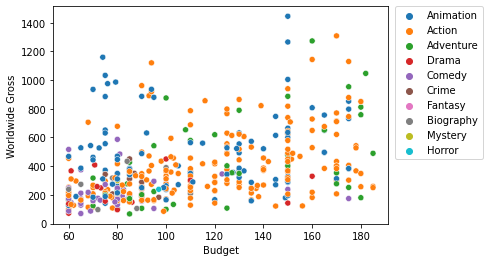

In [ ]:
#step 3: plot
my_plot = sns.scatterplot(x='Budget', y='Worldwide Gross', hue='Genre', data=merge_df)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### Number 2.
My second analysis  is going to be on Metascore vs TN Domestic Gross. This way, I'll be using information gathered from the two different websites to draw a conclusion that wouldn't have been possible before completing this lab. 

I want to explore if a larger metascore correlates to a larger domestic gross. To do this, I begin by "un-cleaning" the data again, removing the units and $ from the domestic gross column and turning them into numbers in order to plot. Initially, I am worried that there might be an increase in the *lie factor* because one axis will be in tens and the other will be in millions but will look like tens becuase I am removing the unit. That will be very misleading if you don't know that axis is in millions, so I will try to be clear about that near the graph. 

Next, I use a scatterplot to plot my data with TN Domestic Gross on the y-axis, and Metascore on the x-axis. Again, I separate the genres to allow for genre-specific conclusions to be made about the data, which would not be possible without this addition. 

Thanks to the figure below, it is very clear to see and conclude that metascore and domestic gross do correlate and relate to each other. There is a clear trend in the data that a higher metascore also means a higher domestic gross.

In [ ]:
#step 1: turn world wide gross into a numeric number
merge_df['TN Domestic Gross'] = merge_df['TN Domestic Gross'].str.replace('$','')
merge_df['TN Domestic Gross'] = merge_df['TN Domestic Gross'].str.replace(',','')
merge_df['TN Domestic Gross'] = merge_df['TN Domestic Gross'].str.replace('M','')
merge_df['TN Domestic Gross'] = pd.to_numeric(merge_df['TN Domestic Gross'])

*Important note for graph below: x-axis (Metascore) is in tens, and the y-axis (TN Domestic Gross) is in millions. 

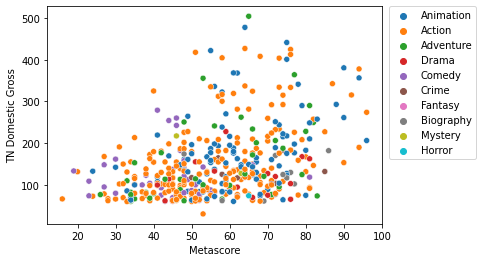

In [ ]:
#step 2: plot
my_plot = sns.scatterplot(x='Metascore', y='TN Domestic Gross', hue='Genre', data=merge_df)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)